# DNA Sequence Data Explorer

Let's open an .ab1 file, aka trace file, aka chromatogram, using [BioPython](https://biopython.org/https://biopython.org/).

In [1]:
import os
from ipywidgets import widgets

sequence_dropdown = widgets.Dropdown(options=os.listdir('./trace_files'))
display(sequence_dropdown)

Dropdown(options=('Cordycep-ITS1-F.ab1', 'Cordycep-ITS1-F.phd.1', 'Cordycep-ITS1-F.seq', 'dense.green.mold-ITS…

Let's take a look at some of the annotation data in the file.

In [2]:
import pandas as pd
from Bio import SeqIO

selected_file = sequence_dropdown.value
selected_file_path = './trace_files/{}'.format(selected_file)

In [3]:
chromatogram = SeqIO.read(selected_file_path, 'abi')

annotations_df = pd.DataFrame.from_dict(chromatogram.annotations,
                                        orient='index',
                                        columns=['Value'])
display(annotations_df)

,Value
sample_well,b'C12'
dye,b'Z-BigDyeV3'
polymer,b'POP7 '
machine_model,b'3730'
run_start,2020-10-22 16:22:07
run_finish,2020-10-22 18:09:12
abif_raw,"{'AEPt1': 9666, 'AEPt2': 9666, 'APFN2': b'KBan..."
molecule_type,DNA


The chromatogram data lives in the `abif_raw` row. Let's take a closer look by mapping the keys in `abiif_raw` with the [ABIF File Format spec](docs/ABIF_File_Format.pdf).

In [4]:
abif_raw = annotations_df.loc['abif_raw']['Value']
pd.DataFrame.from_dict({
  'User':                      abif_raw['User1'],
  'Stop Point':                abif_raw['AEPt1'],
  'Start Point':               abif_raw['ASPt1'],
  'Peak Area Ratio':           abif_raw['phAR1'],
  'Peak Spacing':              abif_raw['SPAC3'],
  'Max Quality Value':         abif_raw['phQL1'],
  'Last Successful Analysis':  abif_raw['BCTS1'],
  'Signal Level for Each Dye': abif_raw['S/N%1'],
  'Sample Comment':            abif_raw['CMNT1'],
  'Container ID':              abif_raw['CTID1'],
  'Container Name':            abif_raw['CTNM1'],
  'Container Owner':           abif_raw['CTOw1']},
    orient='index',
    columns=['Raw Data Fields'])

,Raw Data Fields
User,b'genewiz'
Stop Point,9666
Start Point,1797
Peak Area Ratio,-1
Peak Spacing,14.441
Max Quality Value,99
Last Successful Analysis,b'2020-10-22 18:18:22 -04:00'
Signal Level for Each Dye,"(4177, 5219, 5879, 8419)"
Sample Comment,b'2365253-C12-JoshMcGinnis-30-432885347-JM3'
Container ID,b'07A000045021'


### Now let's take a look at the sequence data

In [5]:
sequence = abif_raw['PBAS1'].decode('UTF-8')
sequence_list = list(sequence)

print("Total Bases: {}\n\n{}".format(len(sequence), ''.join(sequence_list)))

Total Bases: 581

NNNNNNNGNNTCGTTGGTGACCNGCGGAGGGANCATTAACGAGTTTTCCAACTCCCAACCCTTTGTGAACATACCTATCGTTGCTTCGGCGGACTCGCCCAGCGCCTGGACGCGGGCCTGGGCGGCGGCCGTCGGGGGCCCCAAACACTGTATCTACCGGTTTTTCTGAATCCGCCGCAAGGCAAAACAAATGAATCAAAACTTTCAACAACGGATCTCTTGGCTCTGGCATCGATGAAGAACGCAGCGAAATGCGATAAGTAATGTGAATTGCAGAATTCAGTGAATCATCGAATCTTTGAACGCACATTGCGCCCGCCAGCATTCTGGCGGGCATGCCTGTTCGAGCGTCATTTCAACCCTCGACGTCCCCTGGGGGATGTCGGCGTTGGGGACCGGCAGCACACCGCCGCCCCCGAAATGAAGTGGCGGCCCGTCCGCGGCGACCTCTGCGTAGTACCCCAACTCGCACCGGGACCCAGACGTGGCCACGCCGTAAAACGCCCAACTCTGAACGTTGACCTCGGATCAGGTAGGAATACCCGCTGAACTTAANNNNNNNNANNGGNNNNNNNAAAAAN


Let's summarize the bases so we can look at things like the total number of `N` (bases which could not be determine).

In [6]:
sdf = pd.DataFrame(sequence_list, columns=['BASE'])
summary_sdf = pd.DataFrame(sdf['BASE'].value_counts())
summary_sdf.rename(columns={'BASE': 'Total'}, inplace=True)
summary_sdf['Percent of Total'] = summary_sdf['Total'] / summary_sdf['Total'].sum()

summary_sdf_style = summary_sdf.style.format({ 'Percent of Total': "{:.2%}"})
display(summary_sdf_style)

,Total,Percent of Total
C,166,28.57%
G,149,25.65%
A,130,22.38%
T,107,18.42%
N,29,4.99%


### Let's take a look at the Phred (_quality_) scores for the bases in the sequence.

In [33]:
%matplotlib widget

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

plt.style.use('seaborn-notebook')
plt.rcParams.update({ 'xtick.labelsize': 11 })

fig = plt.figure(figsize=(9,2.1))

# position the main graph and slider boxes
main_axis = plt.axes([0.05, 0.41, 0.9, 0.50]) # left bottom width height
slider_axis = plt.axes([0.17, 0.12, 0.75, 0.06])

quality_scores = chromatogram.letter_annotations['phred_quality']
valstep = 50

def build_bar_plot(start, end):
    main_axis.clear()

    seq = sequence_list[start:end]
    ticks = range(len(seq))
    
    main_axis.set_ylim(0)
    main_axis.set_xlim(0)
    main_axis.set_yticks([0, 20, 40, 60, 80])
    main_axis.set_xticks(ticks)
    main_axis.set_xticklabels(seq)
    
    main_axis.bar(ticks, quality_scores[start:end], align='center')
    plt.show()
    
# make the slider
q_slider = Slider(ax=slider_axis,
                  label='Click to Scroll', 
                  valmin=valstep, 
                  valmax=len(quality_scores),
                  valinit=valstep,
                  valstep=valstep)

def update(val):
    start = val - valstep
    build_bar_plot(start, val)
    
q_slider.on_changed(update)
build_bar_plot(0, valstep)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Note how the beginning and the ends of the quality scores taper off. Let's look at some general summary data of the quality scores.

In [8]:
quality_scores_df = pd.DataFrame(quality_scores)
quality_scores_df.describe()

,0
count,581.000000
mean,55.347676
std,14.919888
min,1.000000
25%,58.000000
50%,62.000000
75%,62.000000
max,62.000000


In [32]:
plt.close('all')
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(9,5))

chan_1 = abif_raw['DATA9']
chan_2 = abif_raw['DATA10']
chan_3 = abif_raw['DATA11']
chan_4 = abif_raw['DATA12']

ax2.plot(chan_1[3000:3600], color='r')
ax2.plot(chan_2[3000:3600], color='g')
ax2.plot(chan_3[3000:3600], color='b')
ax2.plot(chan_4[3000:3600], color='w')

#ax2.set_ylim(0)
#ax2.set_xlim(0)

q_slider = Slider(ax=ax3,
                  label='Click to Scroll', 
                  valmin=valstep, 
                  valmax=len(quality_scores),
                  valinit=valstep,
                  valstep=valstep)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

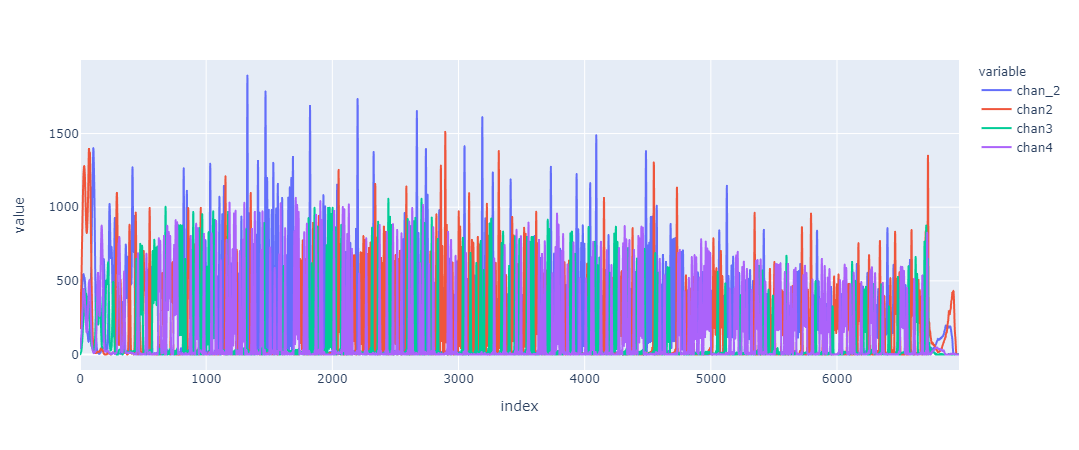

In [111]:
import plotly.express as px

chan_df = pd.DataFrame({ 'chan_2': chan_1, 'chan2': chan_2, 'chan3': chan_3, 'chan4': chan_4 })
chan_df.head()

fig = px.line(chan_df[4000:45000])
fig.show()